# Flight Delay Classifier
After working with flight_delay_model_v1, it seems that getting a reasonable estimate of the delay times from the destination airport, carrier code, and departure date/time is not entirely simple. We ended up with an RMSE of ~38 minutes so we are going to take a step back here and work to build a new model focusing on classifying flights into delayed or on-time. The hope with this new model is we can achieve some degree of useful information out while simplifying the project into a binary rather than continuous estimation.

## Approach
Much of our approach will be identical to our approach with the random forest regressor. We will still be transforming the features via one hot encoding and sin/cosine functions, but we will no longer need to transform the labels as these will now be binary delayed (1) or on-time (0). There will also be a deeper dive into the effictiveness of this model through precision matrices and the precision/recall trade-off versus decision threshold.

For model selection, we will begin with a linear svc as it is amongst the simpler classifiers that we can use. From there, we can mildly complicate things with an SGD classifier before expanding into decision trees and neural networks, for the heck of it.

In [45]:
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict, cross_validate, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from scipy.stats import randint, uniform
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [34]:
# Load all the PDX files
def load_flight_info(data_dir, pat_str):
    """
    Loads a single data frame containing all the data in data_dir with files matching the pat_str
    """
    df = pd.DataFrame()
    for entry in os.listdir(data_dir):
        # Construct full path
        full_path = os.path.join(data_dir, entry)

        # Check if it is actually a file and if it matches the pattern
        if os.path.isfile(full_path) and fnmatch.fnmatch(entry, pat_str):
            df = pd.concat([df, pd.read_csv(full_path, skiprows=7)])
            print(f'Loaded {full_path} added to dataframe.')

    return df

In [35]:
df = load_flight_info('C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays', 'PDX*')

Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_AA_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_AS_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_B6_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_DL_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_F9_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_G4_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_HA_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_MQ_2_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data S

# Data Preparation
The data prepation steps we will undertake prior to classification are as follows:
* Create a new column marking the flight as delayed (1) or on-time (0).
* Drop na values in 'Departure delay (Minutes)'.
* Convert the date and time to a day of the year and departure hour.
* Drop unused columns.
* Create a one hot encoder for the carrier code and destination airport.
* Write sine/cosine transformations of the day of year and departure hour.
* Set up a pipeline to combine all the transformations.

In [36]:
df['Delayed'] = np.where(df['Departure delay (Minutes)'] > 0, 1, 0)

df.dropna(subset='Departure delay (Minutes)', inplace=True)

df['Date'] = pd.to_datetime(df['Date (MM/DD/YYYY)'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['DepartureTimeHour'] = pd.to_datetime(df['Scheduled departure time'], format='%H:%M').dt.hour + pd.to_datetime(df['Scheduled departure time'], format='%H:%M').dt.minute / 60

df = df[['DayOfYear', 'DepartureTimeHour', 'Carrier Code', 'Destination Airport', 'Delayed']]
df = df[df['Carrier Code'] != ' SOURCE: Bureau of Transportation Statistics']

In [37]:
# sine and cosine transformer classes to be used for date and time variables
class SinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.sin(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_sin' for col in input_features]

class CosTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.cos(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_cos' for col in input_features]

In [38]:
# one hot encoder for the categorical values
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

cat_pipeline = Pipeline([
    ('encoder', one_hot_encoder)
])

# Now set up which attributes get which transforms using a ColumnTransformer
time_attribs = ['DepartureTimeHour']
date_attribs = ['DayOfYear']
cat_attribs = ['Carrier Code', 'Destination Airport']

cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ('categorical', one_hot_encoder, cat_attribs),
        ('day_sin', SinTransformer(period=365), date_attribs),
        ('day_cos', CosTransformer(period=365), date_attribs),
        ('hour_sin', SinTransformer(period=24), time_attribs),
        ('hour_cos', CosTransformer(period=24), time_attribs),
])

svc_pipeline = Pipeline([
    ('data_transformer', cyclic_cossin_transformer),
    ('linear_svc', LinearSVC())
])

# Fitting a LinearSVC
In the home stretch of model creation (but not of the whole project since we still need to evaluate, refine, etc), we will split up our training data and train the model. Note that we would usually have split the training data out earlier in this process, but since we are using the same methods as our previous work in flight_delay_model_v1, we had the luxury of waiting until later in the process. It will be a simple train_test_split this time since there is a roughly equal distribution of delayed and on-time flights. From there, we will check the cross-validation score of our linear SVC before diving into some more detailed analysis of its performance.

In [39]:
df_labels = pd.DataFrame(df['Delayed'])
df_features = df.drop('Delayed', axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.2)

x_val_score = cross_val_score(svc_pipeline, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')

In [8]:
pd.Series(x_val_score).describe()

count    5.000000
mean     0.683707
std      0.000774
min      0.682632
25%      0.683358
50%      0.683652
75%      0.684336
max      0.684557
dtype: float64

# Evaluating the Model
Our model seems remarkably consistent with an accuracy of 68% across the cross-validation groups. Notably, the proportion of delayed flights is 43% so our model at least does better than guessing "delayed" for every value, but it is still not a great record. Moreover, it would behoove us to instead look at a confusion matrix to see what kinds of mistakes our model is making. Do we make considerably more false positive rather than false negative predictions?

We can see below that our model predicted 62,641 false positives and 87,537 false negatives. Given that there is not a significant disparity between these two models, we don't seem to have any glaring issues in our model, but we can get some more granular detail through a precision recall curve.

In [9]:
y_train_pred = cross_val_predict(svc_pipeline, X_train, y_train.values.ravel(), cv=5)
cm = confusion_matrix(y_train, y_train_pred)

In [10]:
cm

array([[206149,  62456],
       [ 87878, 118817]])

## Precision Recall Curve
To see where our model does well vs struggles, we will construct a precision recall curve against the threshold of the classifier. Our model is predicting flight delays so where would we prefer our classifier to fall on this range of curves? There are two major scenarios to envision:
1. Users who are always at their gate early and are stressed by delayed flights would prefer a higher precision than recall. Falsely predicting delayed flights would add unnecessary stress to their days while they remain unimpacted by false negatives because they are fine waiting at their gates regardless of the flight status.
2. Users who want to lounge in the airport or at home without checking the flight status would prefer higher recall than precision. If there are too many false negatives, then they will likely miss their flights as they enjoy their days away from their gates. That is a worse tradeoff than a little extra time waiting at the gate because a delay was not predicted.

In [11]:
y_scores = cross_val_predict(svc_pipeline, X_train, y_train.values.ravel(), cv=5, method='decision_function')

In [12]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

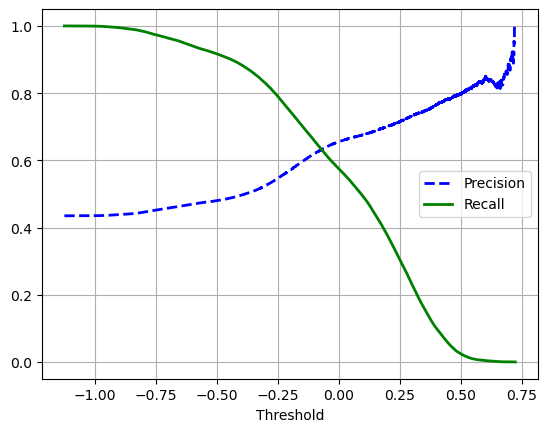

In [13]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.grid()
plt.xlabel('Threshold')
plt.legend(loc='center right');

## Other Models
Now let's see how other, slightly more complex models do in handling this problem. We will go through:
* SGD classifiers
* Decision trees
* Neural networks.

Note that the decision tree will require some tuning that we skipped for the linear SVC and SGD classifier models. Ideally I would also tune the neural network, but I encountered some issues when implementing the grid search--namely that it could not find a suitable solution. I will come back to this to investigate more fully later, but, for now, we will stick with a double hidden layer with 25 nodes each.

I should also point out that this notebook uses scikit-learn's MLPClassifier rather than PyTorch's implementation or TensorFlow's. This is chiefly a package manager limitation. PyTorch has discontinued its support for Anaconda (which this author uses) and TensorFlow is showing conflicts with my current environment. If scikit-learn's implementation proves effective, then I will create a new environment to use PyTorch.

In [14]:
sgd_pipeline = Pipeline([
    ('data_transformer', cyclic_cossin_transformer),
    ('sgd_clf', SGDClassifier())
])

In [15]:
y_scores_sgd = cross_val_predict(sgd_pipeline, X_train, y_train.values.ravel(), cv=5, method='decision_function')

In [16]:
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_train, y_scores_sgd)

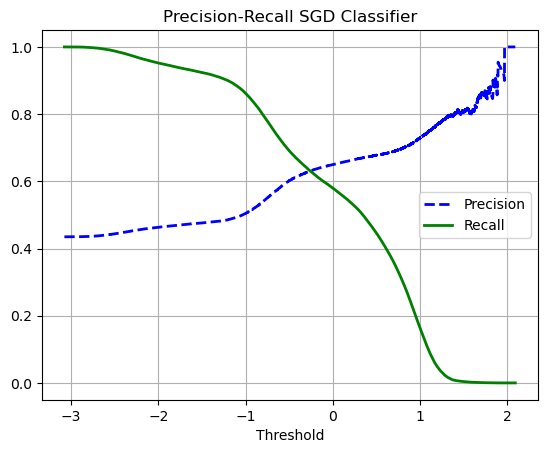

In [17]:
plt.plot(thresholds_sgd, precisions_sgd[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds_sgd, recalls_sgd[:-1], 'g-', label='Recall', linewidth=2)
plt.grid()
plt.xlabel('Threshold')
plt.title('Precision-Recall SGD Classifier')
plt.legend(loc='center right');

In [18]:
tree_pipeline = Pipeline([
    ('data_transformer', cyclic_cossin_transformer),
    ('tree_clf', DecisionTreeClassifier())
])

In [19]:
# We will be tuning our decision tree
param_distribs = {'tree_clf__criterion': ['gini', 'entropy', 'log_loss'],
                  'tree_clf__min_samples_split': randint(low=10, high=30),
                  'tree_clf__min_samples_leaf': randint(low=10, high=30),
                  'tree_clf__max_leaf_nodes': randint(low=100, high=300),
                  'tree_clf__max_depth': randint(low=10, high=30),
                  'tree_clf__max_features': randint(low=100, high=300)}
rnd_tree_search = RandomizedSearchCV(tree_pipeline, param_distributions=param_distribs, 
                                n_iter=10, cv=3, scoring='accuracy')
rnd_tree_search.fit(X_train, y_train.values.ravel())

,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'tree_clf__criterion': ['gini', 'entropy', ...], 'tree_clf__max_depth': <scipy.stats....00296599ACD60>, 'tree_clf__max_features': <scipy.stats....00296599AD0F0>, 'tree_clf__max_leaf_nodes': <scipy.stats....00296595811D0>, ...}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [20]:
best_tree_model = rnd_tree_search.best_estimator_

In [21]:
x_val_score_tree = cross_val_score(best_tree_model, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')
pd.Series(x_val_score_tree).describe()

count    5.000000
mean     0.687273
std      0.000656
min      0.686629
25%      0.686829
50%      0.686977
75%      0.687787
max      0.688144
dtype: float64

In [22]:
y_train_pred_tree = cross_val_predict(best_tree_model, X_train, y_train.values.ravel(), cv=5)
cm_tree = confusion_matrix(y_train, y_train_pred_tree)
cm_tree

array([[207410,  61195],
       [ 87546, 119149]])

In [25]:
neural_pipeline = Pipeline([
    ('data_transformer', cyclic_cossin_transformer),
    ('neural_clf', MLPClassifier())
])

In [50]:
# We will be tuning our decision tree
param_grid = {'neural_clf__hidden_layer_sizes': [(10,), (25,), (50,), (10,10), (25,25), (50,50)],
                  'neural_clf__activation': ['tanh', 'relu', 'logistic'],
                  'neural_clf__solver': ['sgd', 'adam'],
                  'neural_clf__alpha': [0.0001, 0.05],
                  'neural_clf__learning_rate': ['constant', 'adaptive']}
grid_neural_search = GridSearchCV(neural_pipeline, param_grid=param_grid, 
                                cv=3, scoring='accuracy')
grid_neural_search.fit(X_train, y_train.values.ravel())

C:\Users\dloso\miniconda3\envs\stats-ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dloso\miniconda3\envs\stats-ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\dloso\miniconda3\envs\stats-ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\dloso\miniconda3\envs\stats-ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", lin

In [51]:
neural_pipeline = Pipeline([
    ('data_transformer', cyclic_cossin_transformer),
    ('neural_clf', MLPClassifier(hidden_layer_sizes=(25,25)))
])

In [52]:
neural_pipeline.fit(X_train, y_train.values.ravel())

,steps,"[('data_transformer', ...), ('neural_clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('day_sin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
x_val_score_neural = cross_val_score(neural_pipeline, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')
pd.Series(x_val_score_neural).describe()

count    5.000000
mean     0.691126
std      0.001204
min      0.689344
25%      0.690858
50%      0.691111
75%      0.691700
max      0.692615
dtype: float64